<a href="https://colab.research.google.com/github/nihalsuri/thermal-anomaly-detection/blob/main/deploy/rpi/rpi_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import torch
import timm
from PIL import Image 
from torchvision import transforms, models
import cv2

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_name = torch.cuda.get_device_name()
print(device_name)
print(device)

NVIDIA GeForce GTX 1660 Ti with Max-Q Design
cuda


In [30]:
resnet10t = timm.create_model('resnet10t', pretrained=True, num_classes=3)
resnet10t = resnet10t.cuda() if device else resnet10t
resnet10t

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
   

In [31]:
path_res = "C:/Users/Nihal/Desktop/resnet10t-timm-2.pt"
class_mapping = ['healthy', 'misalignment', 'rotor damage']

In [49]:
def preprocess_tensor(path): 
  img = cv2.imread(path)
  img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
  img = Image.fromarray(img)
  img = transforms.functional.crop(img, 190, 380 , 140, 230)
  to_tensor = transforms.ToTensor()
  img = to_tensor(img)
  return img 

def preprocess_img(path):
  img = cv2.imread(path)
  img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
  img = Image.fromarray(img)
  return img 

In [45]:
model_resnet = resnet10t
model_resnet.load_state_dict(torch.load(path_res))

<All keys matched successfully>

In [46]:
path_rotor = "C:/Users/Nihal/Desktop/tests/rotor.png"
path_misal = "C:/Users/Nihal/Desktop/tests/misalignment.png"
path_healthy = "C:/Users/Nihal/Desktop/tests/healthy.png"

rotor_img = mpimg.imread(path_rotor)
misal_img = mpimg.imread(path_misal)
healthy_img = mpimg.imread(path_healthy)

input_test_rotor = preprocess_tensor(path_rotor)
input_test_misal = preprocess_tensor(path_misal)
input_test_healthy = preprocess_tensor(path_healthy)

target_test_rotor = torch.tensor(int(2))
target_test_misal = torch.tensor(int(1))
target_test_healthy = torch.tensor(int(0))

model_resnet.eval()
with torch.no_grad():
   input_test_rotor = torch.unsqueeze(input_test_rotor, 0) # adds another dimension (N C H W)
   input_test_rotor = input_test_rotor.to(device) # send data to GPU or CPU
   predictions_rotor = model_resnet(input_test_rotor) 
   predicted_index_rotor = predictions_rotor[0].argmax(0)
   predicted_test_rotor = class_mapping[predicted_index_rotor]
   expected_test_rotor = class_mapping[target_test_rotor]

   input_test_misal = torch.unsqueeze(input_test_misal, 0) # adds another dimension (N C H W) 
   input_test_misal = input_test_misal.to(device) # send data to GPU or CPU
   predictions_misal = model_resnet(input_test_misal) 
   predicted_index_misal = predictions_misal[0].argmax(0)
   predicted_test_misal = class_mapping[predicted_index_misal]
   expected_test_misal = class_mapping[target_test_misal]

   input_test_healthy = torch.unsqueeze(input_test_healthy, 0) # adds another dimension (N C H W) 
   input_test_healthy = input_test_healthy.to(device) # send data to GPU or CPU
   predictions_healthy = model_resnet(input_test_healthy) 
   predicted_index_healthy = predictions_healthy[0].argmax(0)
   predicted_test_healthy = class_mapping[predicted_index_healthy]
   expected_test_healthy = class_mapping[target_test_healthy]


if(predicted_test_rotor == expected_test_rotor): 
  print("Correctly predicted Rotor damaged!")

if(predicted_test_misal == expected_test_misal): 
  print("Correctly predicted Misalignment!")

if(predicted_test_healthy == expected_test_healthy): 
  print("Correctly predicted Healthy!")

Correctly predicted Rotor damaged!
Correctly predicted Misalignment!
Correctly predicted Healthy!


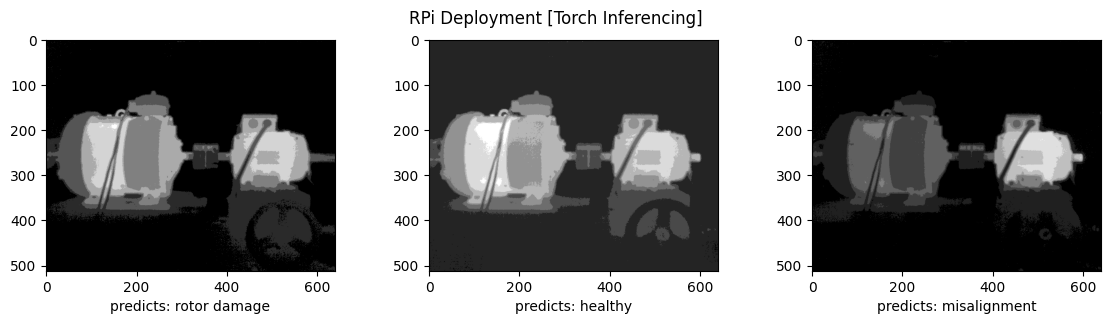

In [55]:
fig = plt.figure()
fig.set_figheight(3)
fig.set_figwidth(14)

plt.subplot(1, 3, 1)
plt.imshow(preprocess_img(path_rotor))
plt.xlabel("predicts: " + predicted_test_rotor)

plt.subplot(1, 3, 2)
plt.imshow(preprocess_img(path_healthy))
plt.xlabel("predicts: " + predicted_test_healthy)

plt.subplot(1, 3, 3)
plt.imshow(preprocess_img(path_misal))
plt.xlabel("predicts: " + predicted_test_misal)

fig.suptitle('RPi Deployment [Torch Inferencing]')
plt.show()